# 🎯 Attention-Based Attribution Model (Optimized)

Interpretable attribution using attention mechanism where **attention weights = attribution scores**.

This is based on the DNAMTA (Deep Neural Network for Multi-Touch Attribution) approach.

**Key Features:**
- Multi-head attention for robust attribution
- Masked attention (proper handling of padding)
- Campaign-level attribution aggregation
- Direct interpretability through attention weights

**Optimizations Applied:**
- `cudnn.benchmark=True` for auto-tuned convolutions
- `TensorFloat-32` precision for faster matrix operations
- `batch_size=2048` for better GPU utilization
- Non-blocking data transfers

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ========== GPU OPTIMIZATIONS ==========
torch.backends.cudnn.benchmark = True  # Auto-tune convolutions
torch.set_float32_matmul_precision('high')  # Use TensorFloat-32 for faster matmul

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch: {torch.__version__}")
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"cuDNN benchmark: {torch.backends.cudnn.benchmark}")

# Paths
DATA_PROCESSED = Path('../data/processed')
RESULTS = Path('../results')
(RESULTS / 'models').mkdir(parents=True, exist_ok=True)
(RESULTS / 'metrics').mkdir(parents=True, exist_ok=True)

PyTorch: 2.6.0+cu124
Device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Memory: 8.6 GB
cuDNN benchmark: True


In [2]:
# Load processed data
with open(DATA_PROCESSED / 'processed_sequences.pkl', 'rb') as f:
    data = pickle.load(f)

train_seq = data['train_sequences']
val_seq = data['val_sequences']
test_seq = data['test_sequences']
config = data['config']

print(f"Data loaded:")
print(f"  Train: {len(train_seq):,}")
print(f"  Val: {len(val_seq):,}")
print(f"  Test: {len(test_seq):,}")
print(f"  Campaigns: {config['n_campaigns']}")

Data loaded:
  Train: 2,631,409
  Val: 563,873
  Test: 563,874
  Campaigns: 676


## PyTorch Dataset

In [3]:
class AttributionDataset(Dataset):
    """Dataset for attribution modeling."""
    
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        return {
            'campaigns': torch.LongTensor(seq['campaigns']),
            'clicks': torch.FloatTensor(seq['clicks']),
            'time_deltas': torch.FloatTensor(seq['time_deltas']),
            'costs': torch.FloatTensor(seq['costs']),
            'mask': torch.FloatTensor(seq['mask']),
            'seq_len': seq['seq_len'],
            'converted': torch.FloatTensor([seq['converted']])
        }

# ========== OPTIMIZED DATALOADER SETTINGS ==========
BATCH_SIZE = 2048  # RTX 4070 8GB handles this with mixed precision

train_loader = DataLoader(
    AttributionDataset(train_seq), 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0,  # Windows Jupyter compatibility
    pin_memory=True
)
val_loader = DataLoader(
    AttributionDataset(val_seq), 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
test_loader = DataLoader(
    AttributionDataset(test_seq), 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)} (batch_size={BATCH_SIZE})")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 1285 (batch_size=2048)
Val batches: 276
Test batches: 276


## Attention Attribution Model

In [4]:
class AttentionAttributionModel(nn.Module):
    """Attention-based model where attention weights directly represent attribution.
    
    Multi-head attention allows the model to learn different aspects of attribution
    (e.g., recency, interaction patterns, channel importance).
    """
    
    def __init__(self, n_campaigns, embed_dim=64, hidden_dim=128, n_heads=4, dropout=0.3):
        super().__init__()
        
        self.n_heads = n_heads
        self.hidden_dim = hidden_dim
        
        # Campaign embeddings (0 is padding)
        self.campaign_embed = nn.Embedding(n_campaigns + 1, embed_dim, padding_idx=0)
        
        # Feature dimension: embed + clicks + time_delta
        self.feature_dim = embed_dim + 2
        
        # Bidirectional LSTM encoder
        self.lstm = nn.LSTM(
            input_size=self.feature_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        
        # Multi-head attention for attribution
        self.attention_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim * 2, 64),
                nn.Tanh(),
                nn.Linear(64, 1)
            ) for _ in range(n_heads)
        ])
        
        # Classifier (concatenates context from all heads)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2 * n_heads, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() > 1:
                nn.init.xavier_uniform_(param)
    
    def forward(self, campaigns, clicks, time_deltas, mask=None, return_attention=False):
        batch_size = campaigns.size(0)
        seq_len = campaigns.size(1)
        
        # Embed and combine features
        camp_embed = self.campaign_embed(campaigns)
        features = torch.cat([
            camp_embed,
            clicks.unsqueeze(-1),
            time_deltas.unsqueeze(-1)
        ], dim=-1)
        
        # LSTM encoding
        lstm_out, _ = self.lstm(features)
        
        # Multi-head attention
        contexts = []
        all_weights = []
        
        for head in self.attention_heads:
            scores = head(lstm_out).squeeze(-1)  # (batch, seq_len)
            
            # Apply mask (prevent attention on padding)
            if mask is not None:
                scores = scores.masked_fill(mask == 0, float('-inf'))
            
            weights = F.softmax(scores, dim=1)
            weights = torch.nan_to_num(weights, nan=0.0)  # Handle edge cases
            
            context = torch.sum(lstm_out * weights.unsqueeze(-1), dim=1)
            contexts.append(context)
            all_weights.append(weights)
        
        # Average attention across heads -> attribution
        avg_attention = torch.stack(all_weights, dim=0).mean(dim=0)
        
        # Classify
        combined = torch.cat(contexts, dim=-1)
        logits = self.classifier(combined)
        
        if return_attention:
            return logits, avg_attention
        return logits

# Create model
model = AttentionAttributionModel(
    n_campaigns=config['n_campaigns'],
    embed_dim=64,
    hidden_dim=128,
    n_heads=4,
    dropout=0.3
).to(device)

# NOTE: torch.compile() requires Triton which is Linux-only
# On Windows, we skip this optimization

print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model Parameters: 844,869
Trainable: 844,869


## Training

In [5]:
# Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)
scaler = GradScaler()

# Class imbalance handling
conversion_rate = config.get('conversion_rate', 0.05)
pos_weight = torch.tensor([1.0 / conversion_rate]).clamp(max=10.0).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print(f"Pos weight: {pos_weight.item():.2f}")

# Training config
EPOCHS = 20
best_auc = 0
patience_counter = 0
EARLY_STOP_PATIENCE = 5

history = {'train_loss': [], 'val_auc': [], 'lr': []}

Pos weight: 10.00


In [6]:
for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0
    
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}'):
        optimizer.zero_grad(set_to_none=True)  # Faster than zero_grad()
        
        # Non-blocking transfers for better GPU overlap
        campaigns = batch['campaigns'].to(device, non_blocking=True)
        clicks = batch['clicks'].to(device, non_blocking=True)
        time_deltas = batch['time_deltas'].to(device, non_blocking=True)
        mask = batch['mask'].to(device, non_blocking=True)
        labels = batch['converted'].to(device, non_blocking=True)
        
        with autocast():
            logits = model(campaigns, clicks, time_deltas, mask)
            loss = criterion(logits, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
    
    scheduler.step()
    
    # Validation
    model.eval()
    val_preds, val_labels = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            campaigns = batch['campaigns'].to(device, non_blocking=True)
            clicks = batch['clicks'].to(device, non_blocking=True)
            time_deltas = batch['time_deltas'].to(device, non_blocking=True)
            mask = batch['mask'].to(device, non_blocking=True)
            
            logits = model(campaigns, clicks, time_deltas, mask)
            probs = torch.sigmoid(logits)
            
            val_preds.extend(probs.cpu().numpy().flatten())
            val_labels.extend(batch['converted'].numpy().flatten())
    
    val_auc = roc_auc_score(val_labels, val_preds)
    current_lr = optimizer.param_groups[0]['lr']
    
    history['train_loss'].append(train_loss / len(train_loader))
    history['val_auc'].append(val_auc)
    history['lr'].append(current_lr)
    
    print(f"Epoch {epoch+1}: Loss={train_loss/len(train_loader):.4f}, Val AUC={val_auc:.4f}, LR={current_lr:.6f}")
    
    # Save best
    if val_auc > best_auc:
        best_auc = val_auc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'val_auc': val_auc,
            'config': config
        }, RESULTS / 'models' / 'attention_best.pt')
        print(f"  → New best! Saved.")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\nEarly stopping after {epoch+1} epochs")
            break

print(f"\n✅ Training complete! Best Val AUC: {best_auc:.4f}")

Epoch 1/20: 100%|██████████| 1285/1285 [01:40<00:00, 12.74it/s]


Epoch 1: Loss=0.4954, Val AUC=0.9186, LR=0.000994
  → New best! Saved.


Epoch 2/20: 100%|██████████| 1285/1285 [01:32<00:00, 13.83it/s]


Epoch 2: Loss=0.4769, Val AUC=0.9193, LR=0.000976
  → New best! Saved.


Epoch 3/20: 100%|██████████| 1285/1285 [01:29<00:00, 14.36it/s]


Epoch 3: Loss=0.4753, Val AUC=0.9190, LR=0.000946


Epoch 4/20: 100%|██████████| 1285/1285 [01:30<00:00, 14.20it/s]


Epoch 4: Loss=0.4741, Val AUC=0.9196, LR=0.000905
  → New best! Saved.


Epoch 5/20: 100%|██████████| 1285/1285 [01:31<00:00, 14.11it/s]


Epoch 5: Loss=0.4729, Val AUC=0.9197, LR=0.000855
  → New best! Saved.


Epoch 6/20: 100%|██████████| 1285/1285 [01:28<00:00, 14.44it/s]


Epoch 6: Loss=0.4721, Val AUC=0.9198, LR=0.000796
  → New best! Saved.


Epoch 7/20: 100%|██████████| 1285/1285 [01:27<00:00, 14.61it/s]


Epoch 7: Loss=0.4710, Val AUC=0.9198, LR=0.000730


Epoch 8/20: 100%|██████████| 1285/1285 [01:27<00:00, 14.77it/s]


Epoch 8: Loss=0.4700, Val AUC=0.9196, LR=0.000658


Epoch 9/20: 100%|██████████| 1285/1285 [01:27<00:00, 14.73it/s]


Epoch 9: Loss=0.4693, Val AUC=0.9196, LR=0.000582


Epoch 10/20: 100%|██████████| 1285/1285 [01:25<00:00, 14.95it/s]


Epoch 10: Loss=0.4685, Val AUC=0.9196, LR=0.000505


Epoch 11/20: 100%|██████████| 1285/1285 [01:26<00:00, 14.88it/s]


Epoch 11: Loss=0.4672, Val AUC=0.9195, LR=0.000428

Early stopping after 11 epochs

✅ Training complete! Best Val AUC: 0.9198


## Training Curves

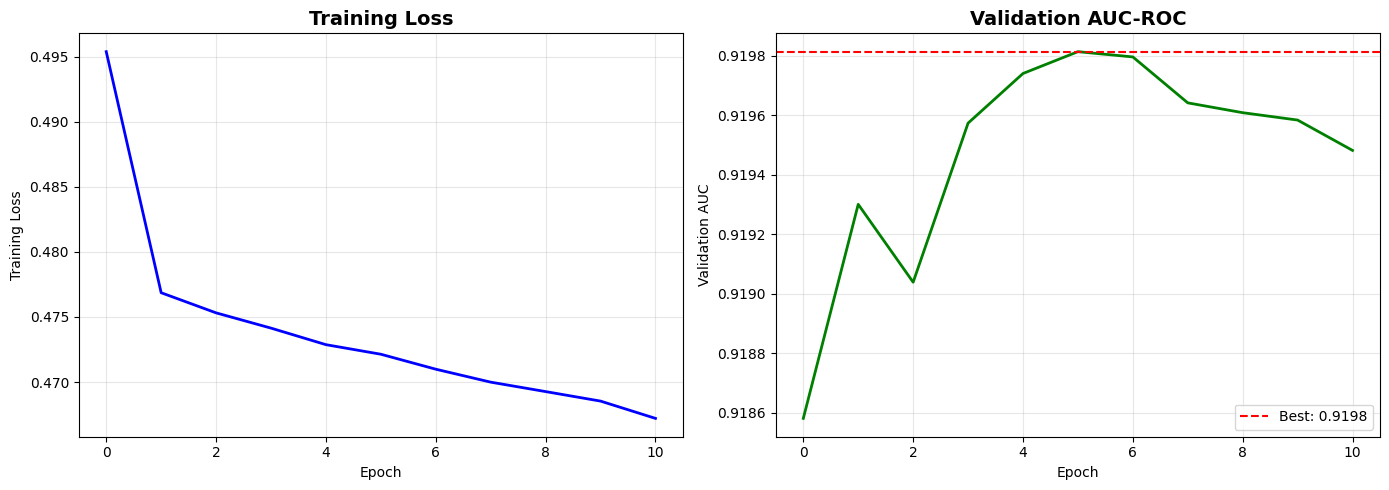

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], 'b-', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].plot(history['val_auc'], 'g-', linewidth=2)
axes[1].axhline(y=best_auc, color='r', linestyle='--', label=f'Best: {best_auc:.4f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation AUC')
axes[1].set_title('Validation AUC-ROC', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
(RESULTS / 'figures').mkdir(parents=True, exist_ok=True)
plt.savefig(RESULTS / 'figures' / 'attention_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## Extract Attribution Weights

In [8]:
# Load best model
checkpoint = torch.load(RESULTS / 'models' / 'attention_best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Loaded best model (AUC: {checkpoint['val_auc']:.4f})")

# Test evaluation
test_preds, test_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Test evaluation'):
        campaigns = batch['campaigns'].to(device, non_blocking=True)
        clicks = batch['clicks'].to(device, non_blocking=True)
        time_deltas = batch['time_deltas'].to(device, non_blocking=True)
        mask = batch['mask'].to(device, non_blocking=True)
        
        logits = model(campaigns, clicks, time_deltas, mask)
        probs = torch.sigmoid(logits)
        
        test_preds.extend(probs.cpu().numpy().flatten())
        test_labels.extend(batch['converted'].numpy().flatten())

test_auc = roc_auc_score(test_labels, test_preds)
print(f"\n📊 Test AUC: {test_auc:.4f}")

Loaded best model (AUC: 0.9198)


Test evaluation: 100%|██████████| 276/276 [00:17<00:00, 15.57it/s]



📊 Test AUC: 0.9208


In [9]:
# Extract attribution for converting users only
converted_seq = [s for s in test_seq if s['converted'] == 1]
print(f"\nConverting users in test set: {len(converted_seq):,}")

converted_loader = DataLoader(
    AttributionDataset(converted_seq), 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

all_attentions = []
all_campaigns = []
all_costs = []

with torch.no_grad():
    for batch in tqdm(converted_loader, desc='Extracting attribution'):
        campaigns = batch['campaigns'].to(device, non_blocking=True)
        clicks = batch['clicks'].to(device, non_blocking=True)
        time_deltas = batch['time_deltas'].to(device, non_blocking=True)
        mask = batch['mask'].to(device, non_blocking=True)
        
        _, attention = model(campaigns, clicks, time_deltas, mask, return_attention=True)
        
        all_attentions.extend(attention.cpu().numpy())
        all_campaigns.extend(batch['campaigns'].numpy())
        all_costs.extend(batch['costs'].numpy())

print(f"Extracted attention for {len(all_attentions):,} converting users")


Converting users in test set: 28,299


Extracting attribution: 100%|██████████| 14/14 [00:00<00:00, 17.88it/s]

Extracted attention for 28,299 converting users


In [10]:
# Aggregate attribution by campaign
campaign_attribution = {}
campaign_cost_attribution = {}

for attn, camps, costs in zip(all_attentions, all_campaigns, all_costs):
    for camp, cost, weight in zip(camps, costs, attn):
        if camp > 0:  # Not padding
            if camp not in campaign_attribution:
                campaign_attribution[camp] = 0.0
                campaign_cost_attribution[camp] = 0.0
            campaign_attribution[camp] += float(weight)
            campaign_cost_attribution[camp] += float(cost * weight)

# Normalize to percentages
total_attr = sum(campaign_attribution.values())
campaign_pct = {k: v / total_attr * 100 for k, v in campaign_attribution.items()}

print("\n📊 Top 10 campaigns by DL attribution:")
for i, camp in enumerate(sorted(campaign_pct, key=campaign_pct.get, reverse=True)[:10], 1):
    print(f"  {i}. Campaign {camp}: {campaign_pct[camp]:.2f}%")


📊 Top 10 campaigns by DL attribution:
  1. Campaign 218: 4.73%
  2. Campaign 327: 3.58%
  3. Campaign 201: 3.56%
  4. Campaign 669: 3.25%
  5. Campaign 641: 3.07%
  6. Campaign 53: 2.77%
  7. Campaign 112: 2.26%
  8. Campaign 330: 2.05%
  9. Campaign 599: 1.87%
  10. Campaign 102: 1.71%


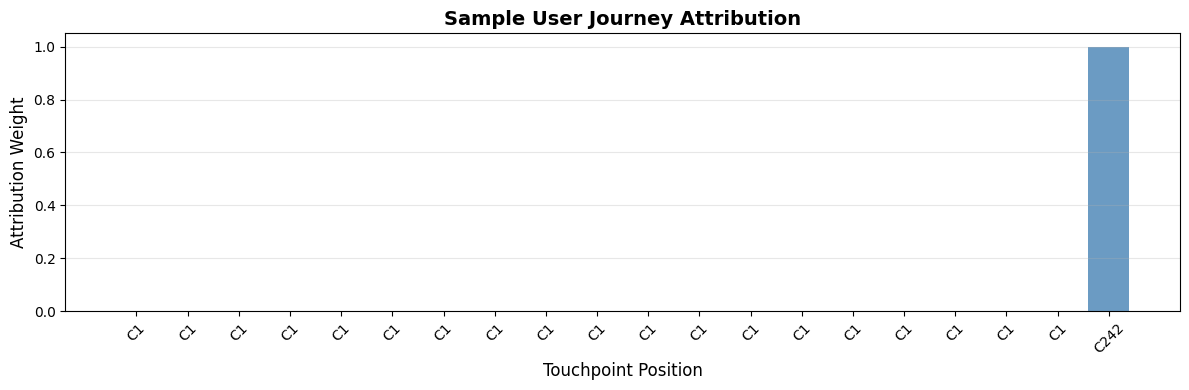

In [11]:
# Visualize attention pattern for sample user
sample_idx = 0
sample_attn = all_attentions[sample_idx]
sample_camps = all_campaigns[sample_idx]

# Filter out padding
valid_mask = sample_camps > 0
valid_attn = sample_attn[valid_mask]
valid_camps = sample_camps[valid_mask]

plt.figure(figsize=(12, 4))
plt.bar(range(len(valid_attn)), valid_attn, color='steelblue', alpha=0.8)
plt.xlabel('Touchpoint Position', fontsize=12)
plt.ylabel('Attribution Weight', fontsize=12)
plt.title('Sample User Journey Attribution', fontsize=14, fontweight='bold')
plt.xticks(range(len(valid_camps)), [f'C{c}' for c in valid_camps], rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS / 'figures' / 'sample_attribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Save results
attention_results = {
    'test_auc': test_auc,
    'best_val_auc': best_auc,
    'history': history,
    'campaign_attribution': campaign_attribution,
    'campaign_pct': campaign_pct,
    'campaign_cost_attribution': campaign_cost_attribution,
    'sample_attentions': all_attentions[:100],
    'sample_campaigns': all_campaigns[:100]
}

with open(RESULTS / 'metrics' / 'attention_results.pkl', 'wb') as f:
    pickle.dump(attention_results, f)

print(f"\n✅ Attention model complete!")
print(f"   Model saved: {RESULTS / 'models' / 'attention_best.pt'}")
print(f"   Results saved: {RESULTS / 'metrics' / 'attention_results.pkl'}")


✅ Attention model complete!
   Model saved: ..\results\models\attention_best.pt
   Results saved: ..\results\metrics\attention_results.pkl


---
**Next:** [06_cac_comparison.ipynb](06_cac_comparison.ipynb) - Compare CAC across attribution models